In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import sys
sys.path.insert(1, '../utils')

from display_images import browse_images, show_images_batch
from preprocessing import TransformRandomCrop, TransformRescale, TransformToTensor, TransformGreyScale
from drivers_dataset import load_data_references, split_refs_train_test, DriversDataset
from custom_model import CustomModel

# I - FIRST GLANCE AT THE DATASET

In [2]:
DATA_PATH = '../data/'
IMGS_TRAIN_FOLDER = DATA_PATH + 'imgs/train'
IMGS_TEST_FOLDER = DATA_PATH + 'imgs/test'
REFS_PATH = DATA_PATH + 'driver_imgs_list.csv'

In [3]:
df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)

In [4]:
df_dataset.head()

subject classname            img  target
0    p002        c0  img_44733.jpg       0
1    p002        c0  img_72999.jpg       0
2    p002        c0  img_25094.jpg       0
3    p002        c0  img_69092.jpg       0
4    p002        c0  img_92629.jpg       0

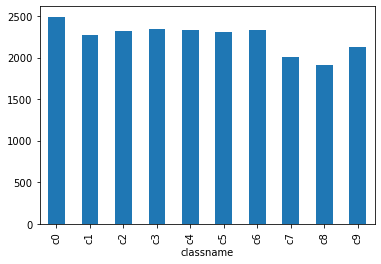

In [5]:
df_dataset.groupby('classname')['img'].count().plot(kind='bar')

In [6]:
#browse_images(df_dataset, IMGS_TRAIN_FOLDER, start_index = 40)

Use the following function to browse the dataset.

### Notes sur le set de train :
    - c0: normal driving   - c1: texting - right               - c2: talking on the phone - right
    - c3: texting - left   - c4: talking on the phone - left   - c5: operating the radio
    - c6: drinking         - c7: reaching behind               - c8: hair and makeup
    - c9: talking to passenger

- Pas de bol le dossier './Test' n'est pas du tout labélisé
- Toujours le même point de vue. Pratique.
- 22400 images dispo en train. (~2200 par classname, de 400 à 1200 par subject)


In [17]:
targets_map = {0: "normal driving", 1: "texting - right", 2: "talking on the phone - right", 3:"texting - left", 4:"talking on the phone - left", 5:"operating the radio", 6:"drinking", 7:"reaching behind", 8:"hair and makeup", 9:"talking to passenger"}
classes = ("normal driving", "texting - right", "talking on the phone - right", "texting - left", "talking on the phone - left", "operating the radio", "drinking", "reaching behind", "hair and makeup", "talking to passenger")

Idées pour plus tard :
- Augmenter les données avec opérations de crop, coloration neutralizée
- Split Train / Test : For each classname shuffle and split 70%train/30%test
- Mélange du dataset ? Ou alors faire apprendre les classes par ordre de parentée ?

In [8]:
dataset = DriversDataset(refs_df = df_dataset, images_dir = IMGS_TRAIN_FOLDER,
    transform = transforms.Compose([
        TransformGreyScale(),
        TransformRescale((144, 192)), # x(3/10) (/ORIGINAL SIZE IS (480, 640)
        TransformRandomCrop((140, 140)),
        TransformToTensor()
    ])
)

--- Pytorch Dataset of 22424 images ready to be used. ---


In [9]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0)

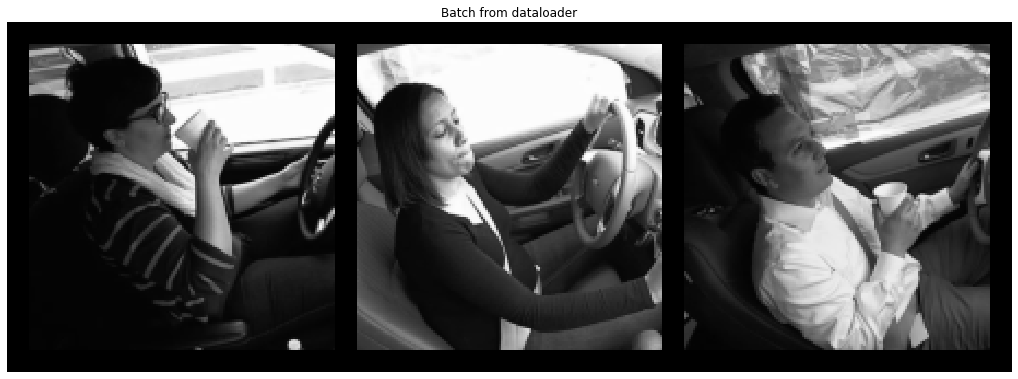

In [10]:
sample_batch = next(iter(dataloader))
show_images_batch(sample_batch)

In [14]:
sample_batch['image'].shape

torch.Size([3, 1, 140, 140])

In [15]:
next(iter(dataloader))['image'].shape

torch.Size([3, 140, 140])

In [27]:
in_shape = (421, 543)

In [29]:
in_channels, in_width, in_height = in_shape if  len(in_shape) == 3 else (1,) + in_shape

In [30]:
in_channels

1

### Dataset is ready to be exploited !!!

# II - BUILD DEEP LEARNING MODEL

In [10]:
import sys
sys.path.insert(1, '../utils')
from custom_model import CustomModel

In [14]:
input_shape = (1, 64, 64)
architecture = [
    'conv2d_64_3_1', 'relu', 'maxpool2d_2',
    'conv2d_128_3_1', 'relu', 'maxpool2d_2',
    'conv2d_256_3_1', 'relu', 'maxpool2d_2',
    'conv2d_512_3_1', 'relu', 'maxpool2d_2',
    'dropout_0.5',
    'flatten',
    'dense_500', 'relu',
    'dropout_0.5',
    'dense_10', 'softmax',
]

In [15]:
mymodel = CustomModel(architecture, input_shape)

In [16]:
mymodel.print_shapes()

--> Input --> :          (1, 64, 64)
--> conv2d_64_3_1 --> :  (64, 64, 64)
--> relu --> :           (64, 64, 64)
--> maxpool2d_2 --> :    (64, 32, 32)
--> conv2d_128_3_1 --> : (128, 32, 32)
--> relu --> :           (128, 32, 32)
--> maxpool2d_2 --> :    (128, 16, 16)
--> conv2d_256_3_1 --> : (256, 16, 16)
--> relu --> :           (256, 16, 16)
--> maxpool2d_2 --> :    (256, 8, 8)
--> conv2d_512_3_1 --> : (512, 8, 8)
--> relu --> :           (512, 8, 8)
--> maxpool2d_2 --> :    (512, 4, 4)
--> dropout_0.5 --> :    (512, 4, 4)
--> flatten --> :        (8192,)
--> dense_500 --> :      (500,)
--> relu --> :           (500,)
--> dropout_0.5 --> :    (500,)
--> dense_10 --> :       (10,)
--> softmax --> :        (10,)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from math import floor
from tqdm import tqdm

In [20]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    print('No GPU available')

mymodel.to(device)


No GPU available


CustomModel(
  (hidden_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_1): ReLU()
  (hidden_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_4): ReLU()
  (hidden_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_7): ReLU()
  (hidden_8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_10): ReLU()
  (hidden_11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_12): Dropout(p=0.5, inplace=False)
  (hidden_13): Flatten()
  (hidden_14): Linear(in_features=8192, out_features=500, bias=True)
  (hidden_15): ReLU()
  (hidden_16): Dropout(p=0.5, inplace=False)
  (hidden_17): 

In [21]:
import torch.optim as optim

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9)

In [25]:
df_dataset = load_data_references(REFS_PATH, IMGS_TRAIN_FOLDER)
df_train_set, df_test_set = split_refs_train_test(df_dataset, split_train_fraction = 0.7, RANDOM_STATE=0.7)

train_set = DriversDataset(refs_df = df_train_set, images_dir = IMGS_TRAIN_FOLDER,
    transform = transforms.Compose([
        TransformRescale((480, 640)),
        TransformRandomCrop((470, 630)),
        TransformToTensor()
    ])
)
test_set = DriversDataset(refs_df = df_test_set, images_dir = IMGS_TRAIN_FOLDER,
    transform = transforms.Compose([
        TransformRescale((480, 640)),
        TransformRandomCrop((470, 630)),
        TransformToTensor()
    ])
)

train_loader = DataLoader(train_set, batch_size=100, pin_memory=True, num_workers=0)

--- Pytorch Dataset of 22424 images ready to be used. ---


In [ ]:
train_set, test_set = split_refs_train_test()

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### a) Utils used to build models and compute accuracy

In [ ]:
def compute_accuracy(model, val_set, gpu=None):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(val_set, batch_size=100, pin_memory=True, num_workers=0)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            if model.needs_input_flat:
                images = images.view(-1, 28*28)
            else:
                images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
    return correct.item()/ len(val_set)

In [ ]:
def train(model, train_set, optimizer, criterion, epochs, batch_size, verbose=1):
    model.to(device)
    print("Training started - {} epochs; batch size: {}; learning rate: {}"
          .format(epochs, batch_size, optimizer.defaults["lr"]))
    train_error = []
    train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=6)
    model.train()
    for epoch in range(epochs):
        epoch_average_loss = 0.0
        if verbose > 1: train_loader = tqdm(train_loader)
        for (images, labels) in train_loader:
            images, labels = images.to(device), labels.to(device)
            if model.needs_input_flat:
                y_pre = model(images.view(batch_size, -1)) 
            else:
                y_pre = model(images.view(batch_size, 1, 28, 28))
            
            # One-hot encoding or labels so as to calculate MSE error:
            if model.with_softmax:
                labels = labels.view(-1, 1)
                labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
                labels_one_hot.zero_()
                labels_one_hot.scatter_(1, labels, 1)
                loss = criterion(y_pre, labels_one_hot)
            else:
                loss = criterion(y_pre, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        train_error.append(epoch_average_loss)
        if verbose > 0: print('Epoch [{}/{}], Loss: {:.4f}'
                              .format(epoch+1, epochs, epoch_average_loss))
    return train_error

In [ ]:
def plot_convergence(model_name, train_error, val_acc):
    plt.plot(range(1, len(train_error) + 1), train_error)
    plt.title("Train error for {} - Validation accuracy: {:.2f}%".format(model_name, val_acc*100))
    plt.xticks(range(1, len(train_error) + 1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    
    
def plot_image(model, val_set, val_index=66):
    (image, label) = val_set[val_index]
    image = image.to(device)
    if model.needs_input_flat:
        image = image.view(-1, 28*28)
    else:
        image = image.view(-1, 1, 28, 28)
    output = model(image)
    _, prediction = torch.max(output.data, 1)
    plt.imshow(image.cpu().view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Prediction label: %d" % prediction)

### b) Application

1) Split train / test

In [8]:
trainloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
testloader = DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        self.drop_out = nn.Dropout(0.5)
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(8192, 500)
        self.relu = nn.ReLU()
    
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x.float())) 
        
        x = self.pool(x) 
        
        
        x = self.relu(self.conv2(x)) 
        x = self.pool(x) 
        x = self.relu(self.conv3(x)) 
        x = self.pool(x) 
        x = self.relu(self.conv4(x)) 
        x = self.pool(x) 
        
        
        x = self.drop_out(x)
        
        
        x = self.flat(x)
        
        
        x = self.relu(self.fc1(x))
       
        
        x = self.drop_out(x) 
        
        
        x = self.softmax(self.fc2(x))
        
        
        return x
        

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.5)
        self.drop3 = nn.Dropout(0.25)


        ## CNN 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32, affine=False)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        ## CNN 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64, affine=False)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        ## CNN 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128, affine=False)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        ## Output
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(8192, 512)
        self.batchnorm4 = nn.BatchNorm1d(512, affine=False)

        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        
        ## CNN 1
        x = self.relu(self.conv1(x.float())) 
        x = self.batchnorm1(x) 
        
        x = self.relu(self.conv2(x)) 
        x = self.batchnorm1(x) 
        
        x = self.pool(x) 
        x = self.drop1(x)
        
        
        ## CNN 2
        x = self.relu(self.conv3(x)) 
        x = self.batchnorm2(x)
        
        x = self.relu(self.conv4(x)) 
        x = self.batchnorm2(x) 
        
        x = self.pool(x) 
        x = self.drop1(x)
        
        ## CNN 3
        x = self.relu(self.conv5(x)) 
        x = self.batchnorm3(x)
        
        x = self.relu(self.conv6(x)) 
        x = self.batchnorm3(x) 
        
        x = self.pool(x) 
        x = self.drop2(x)
        
        ## OUTPUT 
        x = self.flat(x)
        
        x = self.relu(self.fc1(x))
        
        x = self.batchnorm4(x)
        
        x = self.drop2(x)
        
        x = self.relu(self.fc2(x))
        x = self.drop3(x)

        
        x = self.softmax(self.fc3(x))
        
        return x
        

In [ ]:
model = ConvNet2()
model.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
# test = torch.randn(4,3,64,64,)
# print(test)
# print(model(test))

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:

# dataiter = iter(trainloader)
# batch =dataiter.next()
# images, labels = batch['image'], batch['target']

# # create grid of images
# img_grid = torchvision.utils.make_grid(images)

# # show images
# matplotlib_imshow(img_grid, one_channel=False)

# # write to tensorboard
# writer.add_image('four_fashion_mnist_images', img_grid)

In [ ]:
writer.add_graph(model, images.to(device))
writer.close()

In [ ]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

running_loss = 0.0
model.train()
for epoch in range(2):  # loop over the dataset multiple times
    writer = SummaryWriter('../runs/train_epoch_{}'.format(epoch))
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch["image"].to(device), batch["target"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 30 == 29:    # every 300 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 30,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

In [ ]:
def computeAccuracies(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = batch["image"].to(device), batch["target"].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return [accuracy]